In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [3]:
RANDOM_STATE = 42

In [4]:
integral_dataset = pd.read_csv("../data/processed/integral/dataset.csv.gz", index_col="MUTANT")

In [5]:
integral_dataset.columns

Index(['CONS', 'SNP_DEN', 'HAPMAP_SNP_DEN', 'PHYLOP46WAY', 'PHASTCONS46WAY',
       'INTRON', 'MISSENSE', 'NEAR-GENE', 'NCRNA', 'CODING-SYNON',
       'UNTRANSLATED', 'NONSENSE', 'SPLICE', 'STOP-LOSS', 'CHARGE', 'VOLUME',
       'HYDROPHOBICITY', 'GRANTHAM', 'POLARITY', 'EX', 'PAM250', 'BLOSUM',
       'JM', 'VB', 'TRANSITION', 'BINDING', 'ACT_SITE', 'SITE', 'LIPID',
       'METAL', 'CARBOHYD', 'DNA_BIND', 'NP_BIND', 'CA_BIND', 'DISULFID',
       'SE_CYS', 'MOD_RES', 'PROPEP', 'SIGNALP', 'TRANSMEM', 'COMPBIAS', 'REP',
       'MOTIF', 'ZN_FING', 'REGIONS', 'PPI', 'RNABD', 'TF', 'LOC', 'MMBRBD',
       'CHROM', 'POSTMODREC', 'POSTMODENZ', 'AROMATICITY_DIFF',
       'AROMATICITY_LOG_RATIO', 'ISOELECTRIC_POINT_DIFF',
       'ISOELECTRIC_POINT_LOG_RATIO', 'GRAVY_DIFF', 'GRAVY_LOG_RATIO',
       'INSTABILITY_INDEX_DIFF', 'INSTABILITY_INDEX_LOG_RATIO',
       'FLEXIBILITY_DIFF', 'FLEXIBILITY_LOG_RATIO', 'TYPE'],
      dtype='object')

In [6]:
integral_dataset.describe()

,CONS,SNP_DEN,HAPMAP_SNP_DEN,PHYLOP46WAY,PHASTCONS46WAY,INTRON,MISSENSE,NEAR-GENE,NCRNA,CODING-SYNON,...,AROMATICITY_DIFF,AROMATICITY_LOG_RATIO,ISOELECTRIC_POINT_DIFF,ISOELECTRIC_POINT_LOG_RATIO,GRAVY_DIFF,GRAVY_LOG_RATIO,INSTABILITY_INDEX_DIFF,INSTABILITY_INDEX_LOG_RATIO,FLEXIBILITY_DIFF,FLEXIBILITY_LOG_RATIO
count,54326.000000,54326.000000,54326.000000,54389.000000,54389.000000,54849.000000,54849.000000,54849.000000,54849.000000,54849.000000,...,68499.000000,47422.000000,68499.000000,68499.000000,68491.000000,5.115800e+04,68491.000000,61863.000000,6.762400e+04,67624.000000
mean,0.652634,0.064620,0.000143,2.158182,0.671734,0.136101,0.990684,0.060730,0.174114,0.020092,...,0.016528,1.973545,0.694703,2.004476,0.229033,1.986405e+12,14.021421,2.055487,9.295194e-03,2.000630
std,0.086864,0.099475,0.000994,2.287684,0.437809,0.342899,0.096072,0.238837,0.379211,0.140315,...,0.024880,0.327442,0.981196,0.075076,0.170820,1.245322e+14,13.272557,2.271676,6.760691e-03,0.008284
min,0.144895,0.000000,0.000000,-8.217000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.688365,0.000000,-3.385488e+15,0.001250,-84.768255,2.834467e-07,1.967421
25%,0.587777,0.029703,0.000000,0.287000,0.058000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.939356,0.000000,1.991353,0.092083,1.434616e+00,4.196667,1.964406,3.928005e-03,1.994787
50%,0.656068,0.043860,0.000000,1.811000,0.995000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.004167,1.941036,0.167847,2.000000,0.196667,1.939849e+00,10.093750,2.008802,7.928430e-03,2.000770
75%,0.719510,0.064370,0.000000,4.229000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.012500,1.942567,1.221252,2.014951,0.330000,2.427909e+00,20.097500,2.087379,1.336239e-02,2.006237
max,0.897386,1.042402,0.039147,6.424000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.222222,3.662755,6.305908,2.445119,1.673611,9.618253e+15,139.144444,453.213807,4.844643e-02,2.032264


In [7]:
integral_dataset.TYPE.value_counts(normalize=True)

Polymorphism    0.578808
Disease         0.421192
Name: TYPE, dtype: float64

In [8]:
integral_dataset.TYPE.isnull().sum()

0

In [9]:
integral_dataset.shape

(68508, 64)

In [10]:
cat_vars_genomic = ['INTRON','MISSENSE', 'NEAR-GENE', 'NCRNA', 'CODING-SYNON', 'UNTRANSLATED',
       'NONSENSE', 'SPLICE', 'STOP-LOSS']

cat_vars_structural = ['BINDING','ACT_SITE','SITE','LIPID','METAL','CARBOHYD',
                       'DNA_BIND','NP_BIND','CA_BIND','DISULFID','SE_CYS','MOD_RES','PROPEP','SIGNALP',
                       'TRANSMEM','COMPBIAS','REP','MOTIF','ZN_FING','REGIONS','PPI','RNABD','TF','LOC',
                       'MMBRBD','CHROM','POSTMODREC','POSTMODENZ']

cat_vars  = cat_vars_genomic + cat_vars_structural

cont_vars = integral_dataset.columns.drop(cat_vars + ["TYPE"], 1).tolist()


le = LabelEncoder()
X = integral_dataset.drop("TYPE", 1)
y = le.fit_transform(integral_dataset.TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [11]:
impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  

# impute = ('imputer', Imputer(missing_values="NaN", strategy="median"))
scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'Logistic Regression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state=RANDOM_STATE))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2,7]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf'))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
    'xgb':{'pipe':[impute, ('xgb', XGBClassifier(learning_rate=0.01, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1))],
          'params':[{'xgb__min_child_weight': [1, 5, 10], 'xgb__gamma': [0.5, 1, 1.5, 2, 5], 'xgb__subsample': [0.6, 0.8, 1.0], 
                     'xgb__colsample_bytree': [0.6, 0.8, 1.0], 'xgb__max_depth': [3, 4, 5]}],
          'name':'Xtreme Gradient Boosting'
    }
}

In [12]:
X_train.shape

(45900, 63)

In [13]:
X_train.shape[0] / X.shape[0]

0.6699947451392538

In [14]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=4, 
                  scoring='roc_auc', verbose=2, refit=True)

In [15]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] rf__max_depth=3, rf__max_features=4, rf__n_estimators=10 ........
[CV] rf__max_depth=3, rf__max_features=4, rf__n_estimators=10 ........
[CV] rf__max_depth=3, rf__max_features=4, rf__n_estimators=10 ........
[CV] rf__max_depth=3, rf__max_features=4, rf__n_estimators=50 ........
[CV]  rf__max_depth=3, rf__max_features=4, rf__n_estimators=10, total=   1.0s
[CV] rf__max_depth=3, rf__max_features=4, rf__n_estimators=50 ........
[CV]  rf__max_depth=3, rf__max_features=4, rf__n_estimators=10, total=   1.0s
[CV] rf__max_depth=3, rf__max_features=4, rf__n_estimators=50 ........
[CV]  rf__max_depth=3, rf__max_features=4, rf__n_estimators=10, total=   1.1s
[CV] rf__max_depth=3, rf__max_features=4, rf__n_estimators=100 .......
[CV]  rf__max_depth=3, rf__max_features=4, rf__n_estimators=50, total=   2.2s
[CV] rf__max_depth=3, rf__max_features=4, rf__n_estimators=100 .......
[CV]  rf__max_depth=3, rf__max_features=4, rf__n_estimator

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   24.5s


[CV]  rf__max_depth=5, rf__max_features=4, rf__n_estimators=10, total=   1.1s
[CV] rf__max_depth=5, rf__max_features=4, rf__n_estimators=10 ........
[CV]  rf__max_depth=5, rf__max_features=4, rf__n_estimators=10, total=   0.9s
[CV] rf__max_depth=5, rf__max_features=4, rf__n_estimators=10 ........
[CV]  rf__max_depth=3, rf__max_features=7, rf__n_estimators=100, total=   4.1s
[CV] rf__max_depth=5, rf__max_features=4, rf__n_estimators=50 ........
[CV]  rf__max_depth=5, rf__max_features=4, rf__n_estimators=10, total=   1.1s
[CV] rf__max_depth=5, rf__max_features=4, rf__n_estimators=50 ........
[CV]  rf__max_depth=3, rf__max_features=7, rf__n_estimators=100, total=   4.2s
[CV] rf__max_depth=5, rf__max_features=4, rf__n_estimators=50 ........
[CV]  rf__max_depth=3, rf__max_features=7, rf__n_estimators=100, total=   5.4s
[CV] rf__max_depth=5, rf__max_features=4, rf__n_estimators=100 .......
[CV]  rf__max_depth=5, rf__max_features=4, rf__n_estimators=50, total=   2.4s
[CV] rf__max_depth=5, rf_

[CV] rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=10 ......
[CV]  rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=10, total=   1.2s
[CV] rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=10 ......
[CV]  rf__max_depth=7, rf__max_features=sqrt, rf__n_estimators=100, total=   6.8s
[CV] rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=50 ......
[CV]  rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=10, total=   1.4s
[CV] rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=50 ......
[CV]  rf__max_depth=7, rf__max_features=sqrt, rf__n_estimators=100, total=   6.8s
[CV] rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=50 ......
[CV]  rf__max_depth=7, rf__max_features=sqrt, rf__n_estimators=100, total=   6.9s
[CV] rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=100 .....
[CV]  rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=50, total=   5.9s
[CV] rf__max_depth=7, rf__max_features=0.2, rf__n_estimators=100 .....
[CV]  rf__max_dep

[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed:  1.7min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f5a044b8bf8>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=['CONS', 'SNP_DEN', 'HAPMAP_SNP_DEN', 'PHYLOP46WAY', 'PHASTCONS46WAY', 'CHARGE', 'VOLUME', 'HYDROPHOBICITY', 'GRANTHAM', 'POLARITY', 'EX', 'PAM250', 'BLOSUM...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2, 7]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [16]:
gs.best_params_

{'rf__max_depth': 7, 'rf__max_features': 0.2, 'rf__n_estimators': 100}

In [17]:
rf = gs.best_estimator_

In [18]:
_ = rf.predict_proba(X_test)[:, 1]

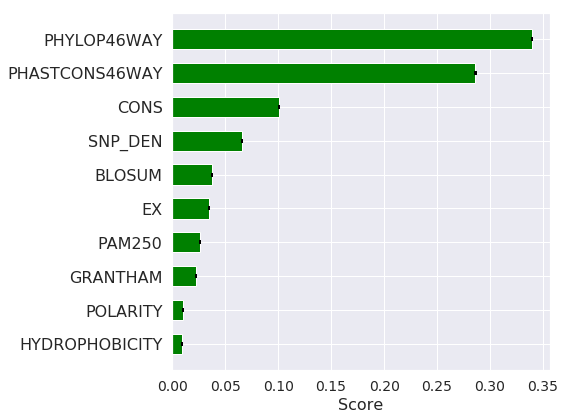

In [21]:
sns.set()
cols = (cont_vars + cat_vars)
ranking_size = 10
forest = rf.steps[1][1]

importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
indices = np.argsort(forest.feature_importances_)[:ranking_size]
importances = importances[:ranking_size][::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
plt.figure(figsize=(8,6))
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
         xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig("/home/marlan/Desktop/importances_integral.pdf", bbox_inches='tight', pad_inches=0.1)


In [20]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [2]:
pd.DataFrame({"score": rf.predict_proba(X_test)[:, 1], "label": y_test}).to_csv("../results/integral/scores_rf.csv", index=False)

NameError: name 'pd' is not defined

In [19]:
roc_curve = pd.concat([pd.Series(fpr,name="fpr"), pd.Series(tpr, name="tpr")], axis=1)
roc_curve.to_csv("../results/integral/auc_rf.csv", index=False)

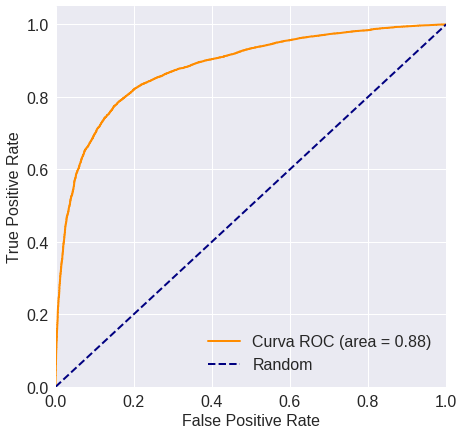

In [20]:
plt.figure(figsize=(7,7))

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

# plt.savefig("/home/marlan/Desktop/auc_integral.pdf", bbox_inches='tight', pad_inches=0.1)

In [25]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(rf.predict(X_test))))

/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


              precision    recall  f1-score   support

     Disease       0.76      0.80      0.78      9522
Polymorphism       0.85      0.82      0.83     13086

 avg / total       0.81      0.81      0.81     22608



/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [37]:
X.columns

Index(['CONS', 'SNP_DEN', 'HAPMAP_SNP_DEN', 'PHYLOP46WAY', 'PHASTCONS46WAY',
       'INTRON', 'MISSENSE', 'NEAR-GENE', 'NCRNA', 'CODING-SYNON',
       'UNTRANSLATED', 'NONSENSE', 'SPLICE', 'STOP-LOSS', 'CHARGE', 'VOLUME',
       'HYDROPHOBICITY', 'GRANTHAM', 'POLARITY', 'EX', 'PAM250', 'BLOSUM',
       'JM', 'VB', 'TRANSITION', 'BINDING', 'ACT_SITE', 'SITE', 'LIPID',
       'METAL', 'CARBOHYD', 'DNA_BIND', 'NP_BIND', 'CA_BIND', 'DISULFID',
       'SE_CYS', 'MOD_RES', 'PROPEP', 'SIGNALP', 'TRANSMEM', 'COMPBIAS', 'REP',
       'MOTIF', 'ZN_FING', 'REGIONS', 'PPI', 'RNABD', 'TF', 'LOC', 'MMBRBD',
       'CHROM', 'POSTMODREC', 'POSTMODENZ', 'AROMATICITY_DIFF',
       'AROMATICITY_LOG_RATIO', 'ISOELECTRIC_POINT_DIFF',
       'ISOELECTRIC_POINT_LOG_RATIO', 'GRAVY_DIFF', 'GRAVY_LOG_RATIO',
       'INSTABILITY_INDEX_DIFF', 'INSTABILITY_INDEX_LOG_RATIO',
       'FLEXIBILITY_DIFF', 'FLEXIBILITY_LOG_RATIO'],
      dtype='object')

In [24]:
features1 = ["EX", "PAM250", "BLOSUM", "JM"] 
features2 = ["HYDROPHOBICITY", "POLARITY"]
features3 = ["CHARGE", "ISOELECTRIC_POINT_LOG_RATIO"]
features4 = ['PHYLOP46WAY', 'PHASTCONS46WAY']
features = X.drop(features1+features2+features3+features4, axis=1).columns.tolist() + [features1] + [features2] + [features3] + [features4]

In [25]:
import rfpimp
I = rfpimp.importances(rf, X_test, y_test, n_samples=-1, features=features)

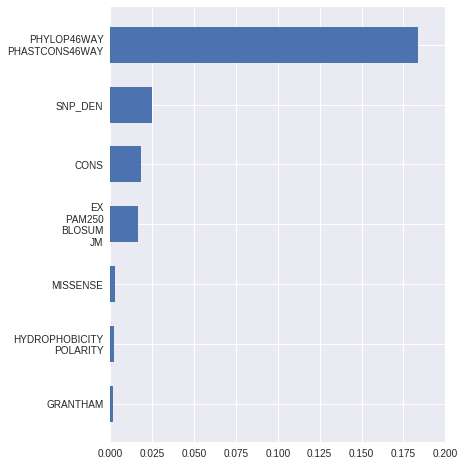

In [26]:
rfpimp.plot_importances(I.iloc[:7], label_fontsize=10, figsize=(6,8), tickstep=1, save="/home/marlan/Desktop/integral_importance_cluster.pdf")